# Twitter US Airline Sentiment

### Executive Summary
In this project, we will analyze the dataset from Kaggle (https://www.kaggle.com/crowdflower/twitter-airline-sentiment) which contains 14,640 tweets posted in February 2015. These tweets are the  passenger comments after their flight with different airline companies. This dataset is slightly reformatted and already contains a sentiment analysis which divides the comments into positive, neutral, and nagative. Since the detail of classifying the tweets is absent, we will perform our own sentiment analysis using TextBlob after the Exploratory Data Analysis (EDA). After EDA, our next step is to create our own sentiment analysis. We extract the polarity of each tweet from the result of TextBlob as our new sentiment and further compare our analysis with the original one. We also create wordclouds for the negative and positive comments. In the last part of our project, we build the text classification model using naive bayes classifier.

### Variable Description
<ul>
<li><b>tweet_id</b>: Tweet ID
<li><b>airline_sentiment</b>: Sentiment of each Tweet (Positive, Neutral, Negative)
<li><b>airline_sentiment_confidence</b>: Information not given
<li><b>negativereason</b>: The reason of each negative comment
<li><b>negativereason_confidence</b>: Information not given
<li><b>airline</b>: The name of the airline company
<li><b>airline_sentiment_gold</b>: Information not given
<li><b>name</b>: The username of each Twitter account
<li><b>negativereason_gold</b>: Information not given
<li><b>retweet_count</b>: The number of re-posting of each Tweet
<li><b>text</b>: The content of each Tweet
<li><b>tweet_coord</b>: Information not given
<li><b>tweet_created</b>: The exact time each tweet was posted
<li><b>tweet_location</b>: Information not given
<li><b>user_timezone</b>: The time zone that each user was in

### Exploratory Data Analysis (EDA)
In this section, we will put the original sentiment analysis into graph and convert count numbers into percentages. We found that the percentage of the negative comments of US airways is greater than the other five companies. To dig deeper, we decide to focus on the negative reasons since we believe that the negative ones are more useful to help improve the airline services and we found that the customer service issue accounts with the most among the ten reasons. 

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from PIL import Image

import re
import os
from nltk.tokenize import WordPunctTokenizer
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from textblob import TextBlob

from sklearn.cross_validation import train_test_split
from textblob.classifiers import NaiveBayesClassifier

/Users/ireneliu/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
df = pd.read_csv('Tweets.csv')

In [3]:
df.shape

(14640, 15)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [5]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [6]:
#The number of tweets per airline
df['airline'].value_counts()

United            3822
US Airways        2913
American          2759
Southwest         2420
Delta             2222
Virgin America     504
Name: airline, dtype: int64

In [7]:
#The percentage of tweets that each airline accounts in this dataset
(df[['airline', 'text']].groupby('airline').count()/len(df)).sort_values(by='text', ascending=False)

,text
airline,
United,0.261066
US Airways,0.198975
American,0.188456
Southwest,0.165301
Delta,0.151776
Virgin America,0.034426


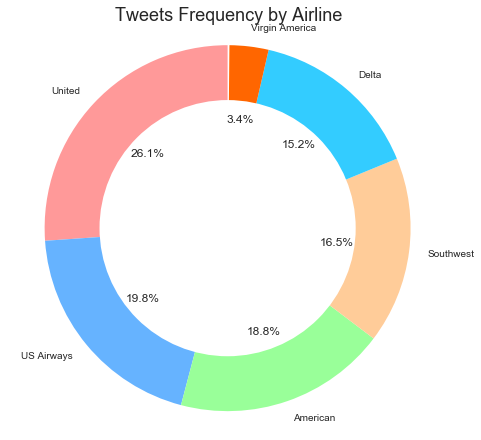

In [8]:
#Pie chart of tweets frequency for each airline
labels = ['United','US Airways','American','Southwest','Delta','Virgin America']
sizes = [0.261, 0.198, 0.188, 0.165, 0.152, 0.0344]
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99', '#33ccff', '#ff6600']
fig1, ax1 = plt.subplots(figsize=(6.5, 6))
ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.1f%%', startangle=90)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

ax1.axis('equal')  
plt.tight_layout()
plt.title('Tweets Frequency by Airline', fontsize=18)

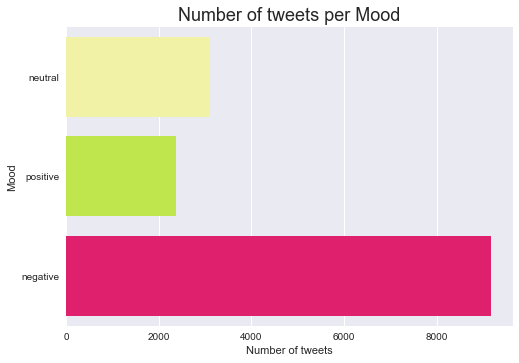

In [9]:
sns.countplot(y='airline_sentiment', data=df, palette=['#ffff99','#ccff33','#ff0066'])
plt.title('Number of tweets per Mood', fontsize=18)
plt.xlabel('Number of tweets')
plt.ylabel('Mood')

In [10]:
#How customers feel about each airline
pd.crosstab(df.airline, df.airline_sentiment)

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


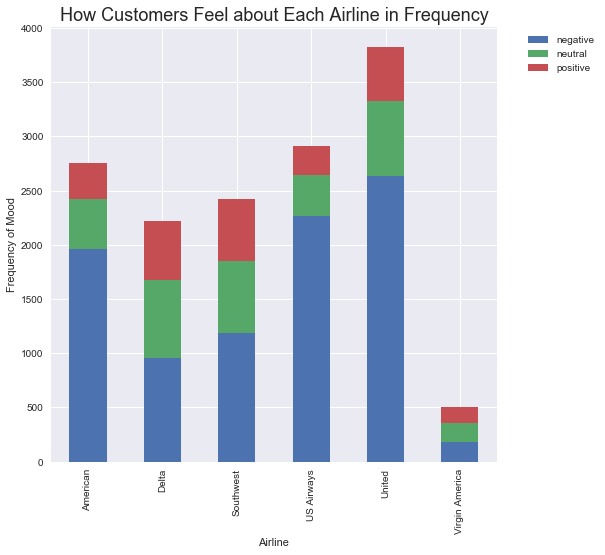

In [27]:
#Visualize sentiment per airline
_ = pd.crosstab(df.airline, df.airline_sentiment).plot(kind="bar",title='How Customers Feel about Each Airline in Frequency',figsize=(8,8),stacked=True)
_.title.set_size(18)
_.set_xlabel('Airline')
_.set_ylabel('Frequency of Mood')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

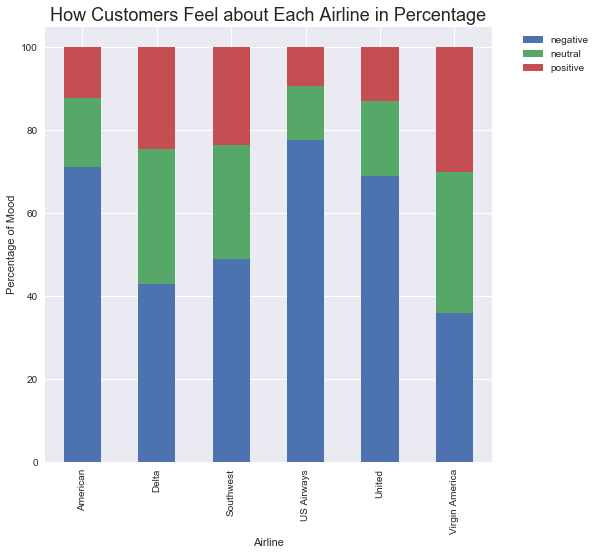

In [28]:
#Visualize sentiment in precentage per airline
_ = pd.crosstab(df.airline, df.airline_sentiment).apply(lambda x: x / x.sum() * 100, axis=1).plot(kind='bar',title='How Customers Feel about Each Airline in Percentage',figsize=(8,8),stacked=True)
_.title.set_size(18)
_.set_xlabel('Airline')
_.set_ylabel('Percentage of Mood')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

##### Focus on Negative Reasons

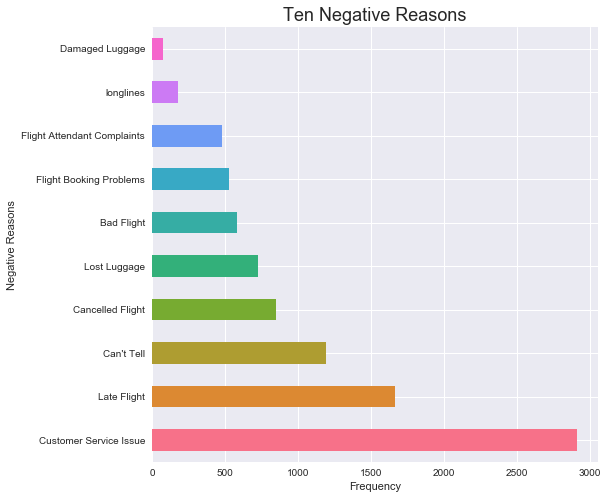

In [26]:
#Visualize how many tweets per negative reasons
colors = sns.color_palette('husl',10)
df.negativereason.value_counts().plot(kind='barh',color=[colors],figsize=(8,8))
plt.title('Ten Negative Reasons', fontsize=18)
plt.xlabel('Frequency')
plt.ylabel('Negative Reasons')

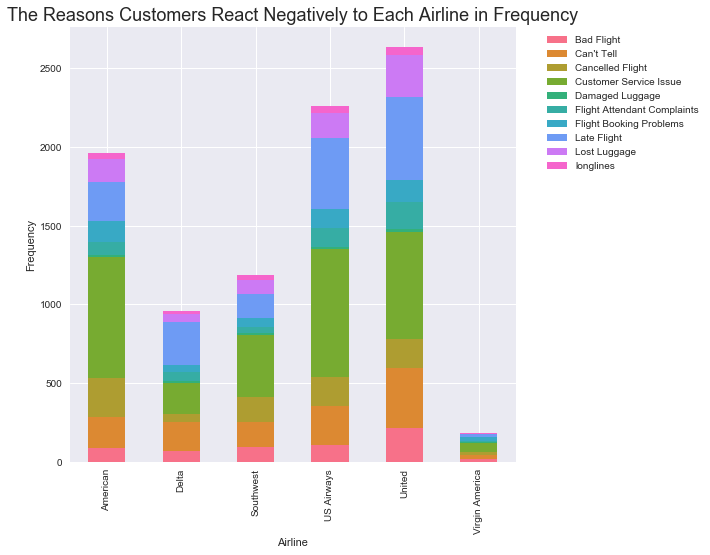

In [30]:
#Visualize negaive reasons per airline
colors = sns.color_palette('husl',10)
pd.crosstab(df.airline, df.negativereason).plot(kind='bar',color=colors,figsize=(8,8),stacked=True)
plt.title('The Reasons Customers React Negatively to Each Airline in Frequency', fontsize=18)
plt.xlabel('Airline')
plt.ylabel('Frequency')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

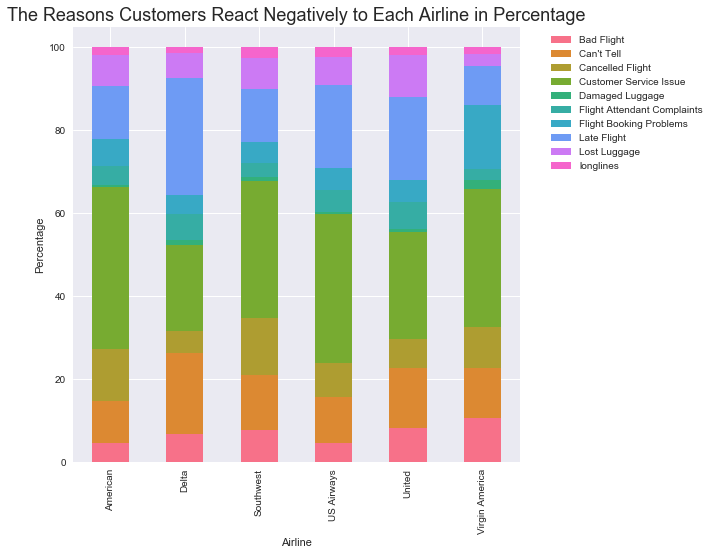

In [29]:
#Visualize negative reasons in precentage per airline
colors=sns.color_palette("husl",10)
pd.crosstab(df.airline, df.negativereason).apply(lambda x: x/x.sum() * 100, axis=1).plot(kind="bar",color = colors,figsize=(8,8),stacked=True)
plt.title('The Reasons Customers React Negatively to Each Airline in Percentage', fontsize=18)
plt.xlabel('Airline')
plt.ylabel('Percentage')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2)

In [16]:
#The top 5 negative reasons
df.negativereason.value_counts().sort_values(ascending=False).head(5)

Customer Service Issue    2910
Late Flight               1665
Can't Tell                1190
Cancelled Flight           847
Lost Luggage               724
Name: negativereason, dtype: int64

### Cleaning
In order to perform sentiment analysis precisely, we need to clean the original text first. In this section, we will remove usernames start with the sign '@', remove hyperlinks start with http:// and www, and uncontract the negatives. After the cleaning, we will drop the stopwords and tokenize every tweet to get things ready for the analysis.

In [17]:
username = '@[A-Za-z0-9]+'
url = 'https?://[^ ]+'
link = 'www.[^ ]+'
combined_p = '|'.join((username, url, link))
neg_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg = re.compile('\b(' + '|'.join(neg_dic.keys()) + ')\b')
tok = WordPunctTokenizer()

def tweet_cleaner(text):
    stripped = re.sub(combined_p, '', text)
    lower_case = stripped.lower()
    neg_handled = neg.sub(lambda x: neg_dic[x.group()], lower_case)
    letters = re.sub("[^a-zA-Z]", " ", neg_handled)
    words = [x for x in tok.tokenize(letters) if len(x) > 1]
    drop_stopwords = [x for x in words if x not in stopwords.words('english')]
    return (" ".join(drop_stopwords)).strip()

In [18]:
clean_tweets = []
for tweet in df.text:
    clean_tweets.append(tweet_cleaner(tweet))
df['clean_text'] = pd.DataFrame(clean_tweets)

### Sentiment Analysis using TextBlob
In this section, we get two outputs from the analysis, polarity and subjectivity. The polarity score indicates the sentiment score of every tweet. We divide this score into two categories, positive (greater than and equal to 0.0) and negative (smaller than 0.0) and also combine the original positive with the original neutral to form a new positive category. The comparison chart of the new sentiment and the original sentiment is shown below. 
<br>The other score we get from this analysis is subjectivity which indicates how the personal feeling is involved in each tweet but we only utilize the polarity score to determine our new sentiment.

In [32]:
polarity = []
for tweet in clean_tweets:
    print tweet
    analysis = TextBlob(tweet)
    print analysis.sentiment
    polarity.append(analysis.sentiment.polarity)

said
Sentiment(polarity=0.0, subjectivity=0.0)
plus added commercials experience tacky
Sentiment(polarity=0.0, subjectivity=0.0)
today must mean need take another trip
Sentiment(polarity=-0.3125, subjectivity=0.6875)
really aggressive blast obnoxious entertainment guests faces amp little recourse
Sentiment(polarity=0.0062500000000000056, subjectivity=0.35)
really big bad thing
Sentiment(polarity=-0.3499999999999999, subjectivity=0.3833333333333333)
seriously would pay flight seats playing really bad thing flying va
Sentiment(polarity=-0.5166666666666666, subjectivity=0.6666666666666666)
yes nearly every time fly vx ear worm go away
Sentiment(polarity=0.45, subjectivity=0.65)
really missed prime opportunity men without hats parody
Sentiment(polarity=0.2, subjectivity=0.2)
well
Sentiment(polarity=0.0, subjectivity=0.0)
amazing arrived hour early good
Sentiment(polarity=0.4666666666666666, subjectivity=0.6)
know suicide second leading cause death among teens
Sentiment(polarity=0.0, subjec

In [33]:
# Compare original sentiment with polarity
df['polarity'] = pd.DataFrame(polarity)
df['sentiment'] = np.where(df['polarity'] < 0.0, 1, 0)
df['sentiment_orig'] = np.where(df['airline_sentiment']=='negative', 1, 0)

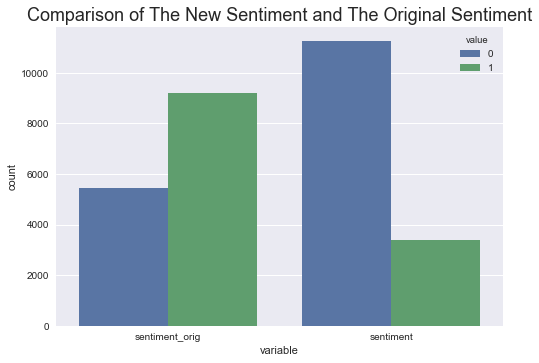

In [35]:
sns.countplot(x="variable", hue="value", data=pd.melt(df[['sentiment_orig', 'sentiment']]))
plt.title('Comparison of The New Sentiment and The Original Sentiment', fontsize=18)
plt.show()

### Wordcloud
In this section, we will create three word clouds using the cleaned text. We use all words in the cleaned text in the first word cloud, the positive words based on our own sentiment analysis for the second word cloud, and the negative words based on our own sentiment analysis for the third word cloud. 

In [37]:
wc_string = df['clean_text'].str.cat(sep=' ')

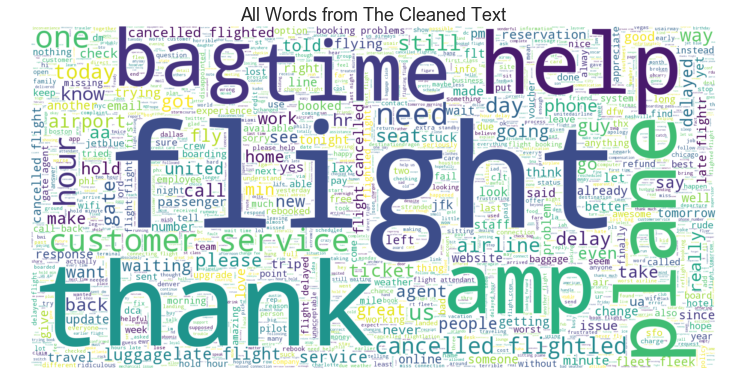

In [46]:
wc = WordCloud(width=1600, height=800,background_color="white", max_words=2000).generate(wc_string)
plt.figure(figsize=(10,10))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('All Words from The Cleaned Text', fontsize=18)
plt.show()

In [47]:
pos_string = df[df.sentiment == 0]['clean_text'].str.cat(sep=' ')

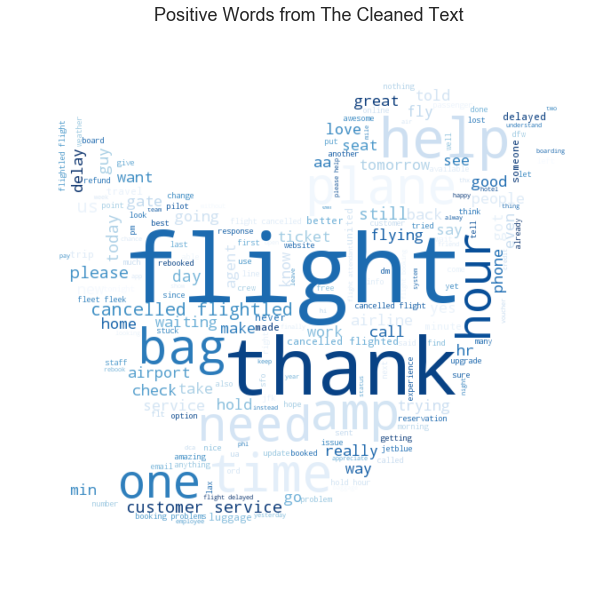

In [48]:
twitter_mask = np.array(Image.open("social-twitter-bird-symbol_318-27588.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Blues",mask=twitter_mask).generate(pos_string)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Positive Words from The Cleaned Text', fontsize=18)
plt.show()

In [49]:
neg_string = df[df.sentiment == 1]['clean_text'].str.cat(sep=' ')

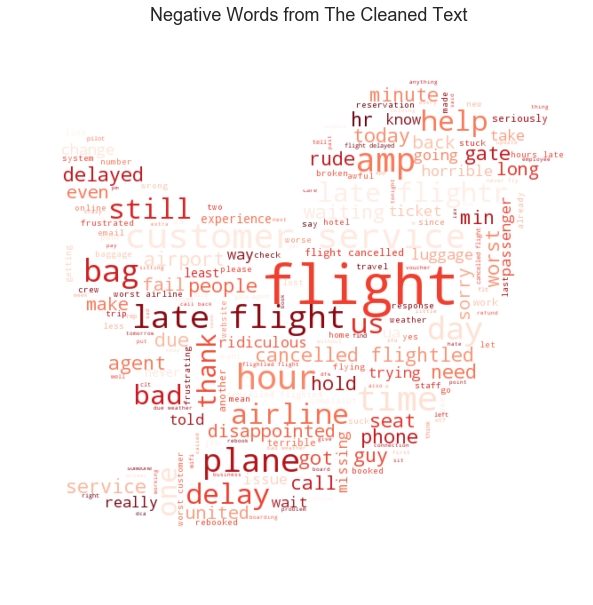

In [50]:
twitter_mask = np.array(Image.open("social-twitter-bird-symbol_318-27588.jpg"))
wc = WordCloud(width=1600, height=800,background_color="white", colormap="Reds",mask=twitter_mask).generate(neg_string)
plt.figure(figsize=(8,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.title('Negative Words from The Cleaned Text', fontsize=18)
plt.show()

### Text Classification with Naive Bayes Classifier
In the last part of our project, we use the naive bayes classifier to build our text classification model and the accuracy we get is around 0.87.

In [51]:
df['Sentiment'] = np.where(df['sentiment'] == 1, 'neg', 'pos')

In [54]:
df2 = np.column_stack((df.clean_text, df.Sentiment)).tolist()
train, test = train_test_split(df2, train_size=0.8)
cl = NaiveBayesClassifier(train)

In [55]:
cl.accuracy(test)

0.8784153005464481